# Data Stream Assignment 1
## By Jeffrey Jose
### 1313512

###### NOTE: When running the code, I have manually entered the file destination for the data under the object FileStream so this has to be changed.

In [1]:
# Required to 'see' dynamic plots in Juypter notebooks
%matplotlib notebook
from collections import Counter

In [2]:
#Importing various packages inorder for the implementation to run smoothly
from skmultiflow.bayes import NaiveBayes
from skmultiflow.data import FileStream
from skmultiflow.data import SEAGenerator
from skmultiflow.evaluation import EvaluatePrequential
from skmultiflow.trees import HAT
from skmultiflow.drift_detection import ADWIN
from skmultiflow.data import WaveformGenerator
from skmultiflow.lazy import KNN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.base import TransformerMixin
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier 
from sklearn.ensemble import RandomForestClassifier

from skmultiflow.core import ClassifierMixin
from skmultiflow.utils.utils import *

# This statement is given incorrectly in the provided code
from skmultiflow.lazy.base_neighbors import BaseNeighbors
from skmultiflow.data import FileStream
from skmultiflow.lazy import KNNClassifier

#Whats the difference between HoeffdingTreeClassifier and HoeffdingTree
from skmultiflow.trees import HoeffdingTreeClassifier, HoeffdingAdaptiveTreeClassifier, HoeffdingTree
from skmultiflow.trees import isoup_tree
from skmultiflow.transform.base_transform import StreamTransform
from skmultiflow.utils import FastBuffer, get_dimensions
from skmultiflow.meta.oza_bagging_adwin import OzaBaggingAdwin
from skmultiflow.meta.adaptive_random_forests import AdaptiveRandomForest

import math
import sys
import warnings
warnings.filterwarnings('ignore')

#### KNNClassifier (Given)

In [3]:
def KNN(n_neighbors=5, max_window_size=1000, leaf_size=30):     # pragma: no cover
    warnings.warn("'KNN' has been renamed to 'KNNClassifier' in v0.5.0.\n"
                  "The old name will be removed in v0.7.0", category=FutureWarning)

    return KNNClassifier(n_neighbors=n_neighbors, max_window_size=max_window_size, leaf_size=leaf_size)


class KNNClassifier(BaseNeighbors, ClassifierMixin):
    #Its like a constructor
    def __init__(self, n_neighbors=5, max_window_size=1000, leaf_size=30, metric='euclidean', weighted_vote = False):
        super().__init__(n_neighbors=n_neighbors, max_window_size=max_window_size, leaf_size=leaf_size, metric=metric)
        self.classes = []
                
    def partial_fit(self, X, y, classes=None, sample_weight=None):

        r, c = get_dimensions(X)

        if classes is not None:
            self.classes = list(set().union(self.classes, classes))

        for i in range(r):
            self.data_window.add_sample(X[i], y[i])

        return self


    def predict(self, X):
        #Add standardization in here
        y_proba = self.predict_proba(X)
        y_pred = np.argmax(y_proba, axis=1)
        return y_pred
    

    #Modify this method
    def predict_proba(self, X):
        #Add standardization in this method too
        r, c = get_dimensions(X)
        if self.data_window is None or self.data_window.size < self.n_neighbors:
            # The model is empty, defaulting to zero
            return np.zeros(shape=(r, 1))
        proba = []

        self.classes = list(set().union(self.classes, np.unique(self.data_window.targets_buffer.astype(np.int))))
        new_dist, new_ind = self._get_neighbors(X)

        for i in range(r):
            votes = [0.0 for _ in range(int(max(self.classes) + 1))]
            for index in new_ind[i]:
                votes[int(self.data_window.targets_buffer[index])] += 1. / len(new_ind[i])
            proba.append(votes)

        return np.asarray(proba)

#### MyKNNClassifier Implementation

In [4]:
class MyKNNClassifier(KNNClassifier): # ... 
    def __init__(self, n_neighbors=5, max_window_size=1000, leaf_size=30, metric='euclidean', weighted_vote=False,
                 standardize = False):
        self.weighted_vote = weighted_vote
        self.standardize = standardize
        super().__init__(n_neighbors=n_neighbors, max_window_size=max_window_size, leaf_size=leaf_size, metric=metric)
        self.window_size = max_window_size
        self.window = None

        self.__configure()

    def __configure(self):
        self.window = FastBuffer(max_size=self.window_size)
        
    def partial_fit(self, X, y, classes=None, sample_weight=None):
        if(self.standardize == True):
            instance = np.array(X)
            X = self.transform_vector(instance)
            self.window.add_element(X)
        r, c = get_dimensions(X)

        if classes is not None:
            self.classes = list(set().union(self.classes, classes))

        for i in range(r):
            self.data_window.add_sample(X[i], y[i])

        return self
    
    
    def standardization(self, X):   
        #scaler = MinMaxScaler(feature_range=(0, 1))
        #scaler = scaler.fit(X)
        #print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
        #normalize the dataset and print the first 5 rows
        #normalized = scaler.transform(X)
        
        #return X
        
        scaler = StandardScaler()
        scaler.fit(X)
        normalized = scaler.fit_transform(X)
        X = normalized
        
        return X
    

    #Modify this method
    def predict_proba(self, X):
        #print("Not Weighted")
        #Add standardization in this method too
        if(self.standardize == True):
            instance = np.array(X)
            X = self.transform_vector(instance)
            
        r, c = get_dimensions(X)

        #print("Value of R: ", r) # r = 1
        #print("Value of C: ", c) # c = 2
        if self.data_window is None or self.data_window.size < self.n_neighbors:
            # The model is empty, defaulting to zero
            return np.zeros(shape=(r, 1))
        proba = []

        self.classes = list(set().union(self.classes, np.unique(self.data_window.targets_buffer.astype(np.int))))
        new_dist, new_ind = self._get_neighbors(X)
       
        if(self.weighted_vote == False):
            #print("Not Weighted")
            for i in range(r):
                votes = [0.0 for _ in range(int(max(self.classes) + 1))]
                for index in new_ind[i]:
                    votes[int(self.data_window.targets_buffer[index])] += 1. / len(new_ind[i])

                proba.append(votes)
                
        else:
            #print("Weighted")
            position = 0
            for i in range(r):
                votes = [0.0 for _ in range(int(max(self.classes) + 1))]
                for index in new_ind[i]:
                    votes[int(self.data_window.targets_buffer[index])] += np.sum((1. / new_dist[i][position])) / len(new_ind[i])
                    position = position + 1
                proba.append(votes)

        return np.asarray(proba)

    
    def calculate_mean(self, column_index):
        mean = 0.
        if not self.window.is_empty():
            mean = np.nanmean(np.array(self.window.get_queue())[:, column_index])
        return mean

    def calculate_stddev(self, column_index):
        std = 1.
        if not self.window.is_empty():
            std = np.nanstd(np.array(self.window.get_queue())[:, column_index])
        if(std == 0.):
            std = 1.
        return std
    
    def transform_vector(self, X):
        r, c = get_dimensions(X)
        for i in range(r):
            row = np.copy([X[i][:]])
            for j in range(c):
                value = X[i][j]
                mean = self.calculate_mean(j)
                standard_deviation = self.calculate_stddev(j)
                standardized = (value - mean) / standard_deviation
                X[i][j] = standardized
            self.window.add_element(row)
        return X

## First Dataset (data_n30000.csv)

In [5]:
#Read the stream 
stream = FileStream("C:/Users/jeffr/OneDrive/Desktop/Data Stream/Assignment_One/dataset/data_n30000.csv")
stream.prepare_for_use()

#stream.next_sample(10)
#stream.n_remaining_samples()
#X, y = stream.next_sample(5000)

In [6]:
# Methods used
# Learning Alogrithms: KNN, HoeffingTree, Naive Bayes
# Ensemble Algorithms: Hoeffding Adaptive Tree
# Baseline Algorithm: No-Change Classifier

In [7]:
metrics = ['accuracy', 'kappa', 'kappa_m', 'kappa_t', 'running_time', 'model_size'] 
evaluator = EvaluatePrequential(max_samples = 30000, n_wait = 100, show_plot = True, metrics = metrics) 

## Experiment 1: kNN Variations And Other Algorithms
#### For this experiment, I evaluated each method one by one but currently I just have them coded so that they can only be evaluated together. This does not give the recall for each method but rather for only the last method which is the standard Hoeffding Tree.

In [8]:
my_knn = MyKNNClassifier(standardize = False, weighted_vote = False)

In [9]:
my_knn

MyKNNClassifier(leaf_size=30, max_window_size=1000, metric='euclidean',
                n_neighbors=5, standardize=False, weighted_vote=False)

<IPython.core.display.Javascript object>


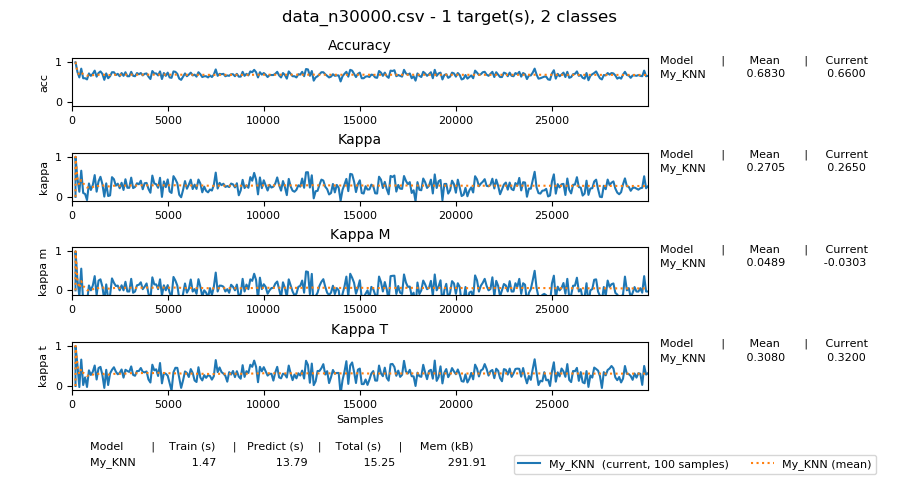

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [22.16s]
Processed samples: 30000
Mean performance:
My_KNN - Accuracy     : 0.6830
My_KNN - Kappa        : 0.2705
My_KNN - Kappa T      : 0.3080
My_KNN - Kappa M      : 0.0489
My_KNN - Training time (s)  : 1.47
My_KNN - Testing time  (s)  : 13.79
My_KNN - Total time    (s)  : 15.25
My_KNN - Size (kB)          : 291.9121
Recall per class
Class 0: 0.751072340835703
Class 1: 0.5269031046293228


In [10]:
evaluator.evaluate(stream = stream, model = [my_knn], model_names = ['My_KNN'])
cm = evaluator.get_mean_measurements(0).confusion_matrix
print("Recall per class")
for i in range(cm.n_classes):
    recall = cm.data[(i,i)]/cm.sum_col[i] \
    if cm.sum_col[i] != 0 else 'Ill-defined'
    print("Class {}: {}".format(i, recall))

In [12]:
#All the methods that we need to test
knn = KNNClassifier()
ht = HoeffdingTreeClassifier(leaf_prediction = 'mc')
htnb = HoeffdingTreeClassifier(leaf_prediction = 'nb')
nb = NaiveBayes()
hoef = HoeffdingTreeClassifier()

In [13]:
knn

KNNClassifier(leaf_size=30, max_window_size=1000, metric='euclidean',
              n_neighbors=5, weighted_vote=None)

<IPython.core.display.Javascript object>


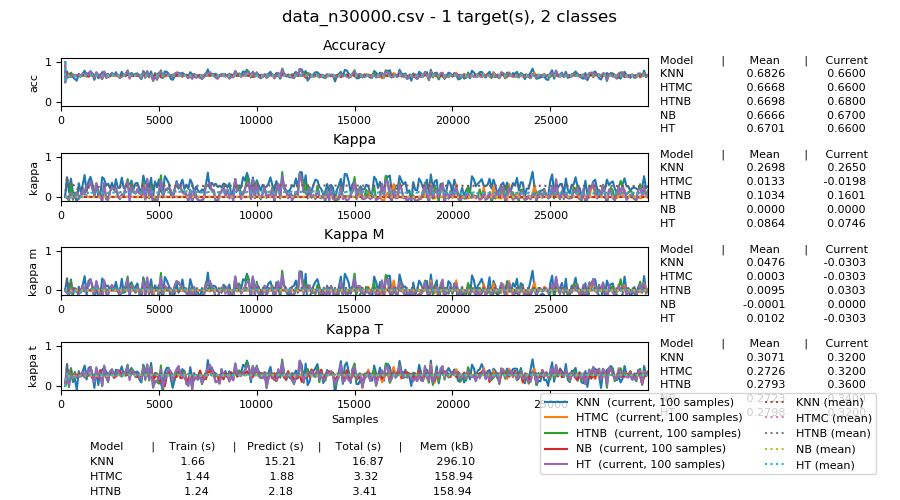

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [43.17s]
Processed samples: 30000
Mean performance:
KNN - Accuracy     : 0.6826
KNN - Kappa        : 0.2698
KNN - Kappa T      : 0.3071
KNN - Kappa M      : 0.0476
KNN - Training time (s)  : 1.66
KNN - Testing time  (s)  : 15.21
KNN - Total time    (s)  : 16.87
KNN - Size (kB)          : 296.1016
HTMC - Accuracy     : 0.6668
HTMC - Kappa        : 0.0133
HTMC - Kappa T      : 0.2726
HTMC - Kappa M      : 0.0003
HTMC - Training time (s)  : 1.44
HTMC - Testing time  (s)  : 1.88
HTMC - Total time    (s)  : 3.32
HTMC - Size (kB)          : 158.9424
HTNB - Accuracy     : 0.6698
HTNB - Kappa        : 0.1034
HTNB - Kappa T      : 0.2793
HTNB - Kappa M      : 0.0095
HTNB - Training time (s)  : 1.24
HTNB - Testing time  (s)  : 2.18
HTNB - Total time    (s)  : 3.41
HTNB - Size (kB)          : 158.9424
NB - Accuracy     : 0.6666
NB - Kappa        : 0.0000
NB - Kappa T      : 0.2

In [25]:
#Evaluating all methods together
evaluator.evaluate(stream = stream, model = [knn, ht, htnb, nb, hoef], model_names = ['KNN', 'HTMC', 'HTNB', 'NB', 'HT'])
cm = evaluator.get_mean_measurements(0).confusion_matrix

print("Recall per class")
for i in range(cm.n_classes):
    recall = cm.data[(i,i)]/cm.sum_col[i] \
    if cm.sum_col[i] != 0 else 'Ill-defined'
    print("Class {}: {}".format(i, recall))

## Experiment 2: Hyperparameter tuning for kNN

#### KNN Using Majority Classifier

In [11]:
k_values = [1, 3, 20]
window_sizes = [15, 600, 6000]

evaluator = EvaluatePrequential(max_samples=30000, n_wait=100, show_plot=False, metrics=metrics)

for k in k_values:
    for w in window_sizes:
        myknnAltModel = MyKNNClassifier(standardize = False, weighted_vote = False, max_window_size=w, n_neighbors=k)
        evaluator.evaluate(stream=stream, model=[myknnAltModel], model_names=[("KNN k=" + str(k) + " w=" + str(w))])
        cm = evaluator.get_mean_measurements(0).confusion_matrix
        print("Recall per class")
        for i in range(cm.n_classes):
            recall = cm.data[(i,i)]/cm.sum_col[i] \
            if cm.sum_col[i] != 0 else 'Ill-defined'
            print("Class {}: {}".format(i, recall))
        print("\n")


Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [6.58s]
Processed samples: 30000
Mean performance:
KNN k=1 w=15 - Accuracy     : 0.8058
KNN k=1 w=15 - Kappa        : 0.5870
KNN k=1 w=15 - Kappa T      : 0.5760
KNN k=1 w=15 - Kappa M      : 0.4173
KNN k=1 w=15 - Training time (s)  : 1.30
KNN k=1 w=15 - Testing time  (s)  : 4.54
KNN k=1 w=15 - Total time    (s)  : 5.83
KNN k=1 w=15 - Size (kB)          : 6.7988
Recall per class
Class 0: 0.9008542141230068
Class 1: 0.6693627450980392


Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [12.76s]
Processed samples: 30000
Mean performance:
KNN k=1 w=600 - Accuracy     : 0.7154
KNN k=1 w=600 - Kappa        : 0.3458
KNN k=1 w=600 - Kappa T      : 0.3788
KNN k=1 w=600 - Kappa M      : 0.1462
KNN k=1 w=600 - Training time (s)  : 1.48
KNN k=1 w=600 - Testing time  (s)  : 9.49
KNN k=1 w=600 - Total time    

#### KNN Using Weighted Voting

In [ ]:
k_values = [1, 3, 20]
window_sizes = [15, 600, 6000]

evaluator = EvaluatePrequential(max_samples=30000, n_wait=100, show_plot=False, metrics=metrics)

for k in k_values:
    for w in window_sizes:
        myknnAltModel = MyKNNClassifier(standardize = False, weighted_vote = True, max_window_size=w, n_neighbors=k)
        evaluator.evaluate(stream=stream, model=[myknnAltModel], model_names=[("KNN k=" + str(k) + " w=" + str(w))])
        cm = evaluator.get_mean_measurements(0).confusion_matrix
        print("Recall per class")
        for i in range(cm.n_classes):
            recall = cm.data[(i,i)]/cm.sum_col[i] \
            if cm.sum_col[i] != 0 else 'Ill-defined'
            print("Class {}: {}".format(i, recall))
        print("\n")


#### KNN Using Standardisation

In [49]:
k_values = [1, 3, 20]
window_sizes = [15, 600, 6000]

evaluator = EvaluatePrequential(max_samples=30000, n_wait=100, show_plot=False, metrics=metrics)

for k in k_values:
    for w in window_sizes:
        myknnAltModel = MyKNNClassifier(standardize = True, weighted_vote = False, max_window_size=w, n_neighbors=k)
        evaluator.evaluate(stream=stream, model=[myknnAltModel], model_names=[("KNN k=" + str(k) + " w=" + str(w))])
        cm = evaluator.get_mean_measurements(0).confusion_matrix
        print("Recall per class")
        for i in range(cm.n_classes):
            recall = cm.data[(i,i)]/cm.sum_col[i] \
            if cm.sum_col[i] != 0 else 'Ill-defined'
            print("Class {}: {}".format(i, recall))
        print("\n")


Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [22.70s]
Processed samples: 30000
Mean performance:
KNN k=1 w=15 - Accuracy     : 0.7129
KNN k=1 w=15 - Kappa        : 0.3776
KNN k=1 w=15 - Kappa T      : 0.3734
KNN k=1 w=15 - Kappa M      : 0.1387
KNN k=1 w=15 - Training time (s)  : 9.33
KNN k=1 w=15 - Testing time  (s)  : 12.45
KNN k=1 w=15 - Total time    (s)  : 21.78
KNN k=1 w=15 - Size (kB)          : 9.2676
Recall per class
Class 0: 0.8079499047100462
Class 1: 0.5602973327503279


Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [74.46s]
Processed samples: 30000
Mean performance:
KNN k=1 w=600 - Accuracy     : 0.6978
KNN k=1 w=600 - Kappa        : 0.3093
KNN k=1 w=600 - Kappa T      : 0.3403
KNN k=1 w=600 - Kappa M      : 0.0933
KNN k=1 w=600 - Training time (s)  : 31.91
KNN k=1 w=600 - Testing time  (s)  : 39.86
KNN k=1 w=600 - Total tim

## Second Dataset (covtype_numeric.csv)

In [12]:
stream_ = FileStream("C:/Users/jeffr/OneDrive/Desktop/Data Stream/Assignment_One/dataset/covtype_numeric.csv")
stream_.prepare_for_use()

## Experiment 3: Real Data

##### KNN(k = 5, w = 1000, std = True)

In [8]:
my_knn1 = MyKNNClassifier(standardize = True, weighted_vote = False)
my_knn1

MyKNNClassifier(leaf_size=30, max_window_size=1000, metric='euclidean',
                n_neighbors=5, standardize=True, weighted_vote=False)

<IPython.core.display.Javascript object>


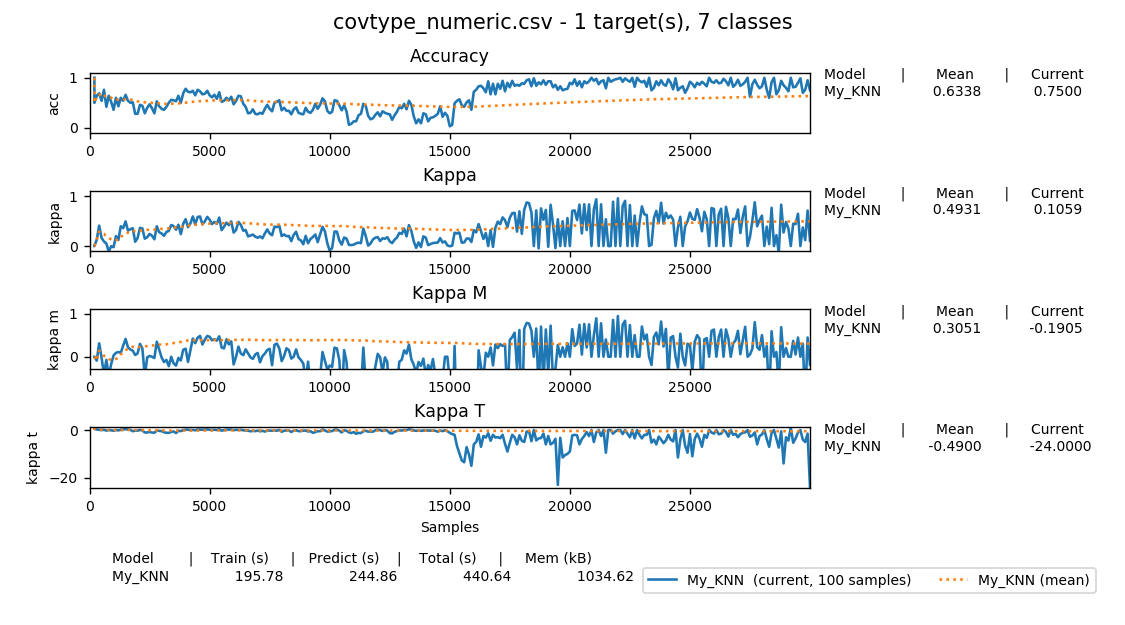

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [477.33s]
Processed samples: 30000
Mean performance:
My_KNN - Accuracy     : 0.6338
My_KNN - Kappa        : 0.4931
My_KNN - Kappa T      : -0.4900
My_KNN - Kappa M      : 0.3051
My_KNN - Training time (s)  : 195.78
My_KNN - Testing time  (s)  : 244.86
My_KNN - Total time    (s)  : 440.64
My_KNN - Size (kB)          : 1034.6230
Recall per class
Class 0: Ill-defined
Class 1: 0.4937791601866252
Class 2: 0.8302407932011332
Class 3: 0.3092695429303716
Class 4: 0.5864170657379191
Class 5: 0.4270880361173815
Class 6: 0.35835616438356166
Class 7: 0.5123789020452099


In [25]:
metrics = ['accuracy', 'kappa', 'kappa_m', 'kappa_t', 'running_time', 'model_size'] 
evaluator = EvaluatePrequential(max_samples = 30000, n_wait = 100, show_plot = True, metrics = metrics) 

evaluator.evaluate(stream = stream_, model = [my_knn1], model_names = ['My_KNN'])
cm = evaluator.get_mean_measurements(0).confusion_matrix

print("Recall per class")
for i in range(cm.n_classes):
    recall = cm.data[(i,i)]/cm.sum_col[i] \
    if cm.sum_col[i] != 0 else 'Ill-defined'
    print("Class {}: {}".format(i, recall))

###### KNN(k = 5, w = 1000, maj)

In [11]:
knn_data_ = KNNClassifier()
knn_data_

KNNClassifier(leaf_size=30, max_window_size=1000, metric='euclidean',
              n_neighbors=5, weighted_vote=None)

<IPython.core.display.Javascript object>


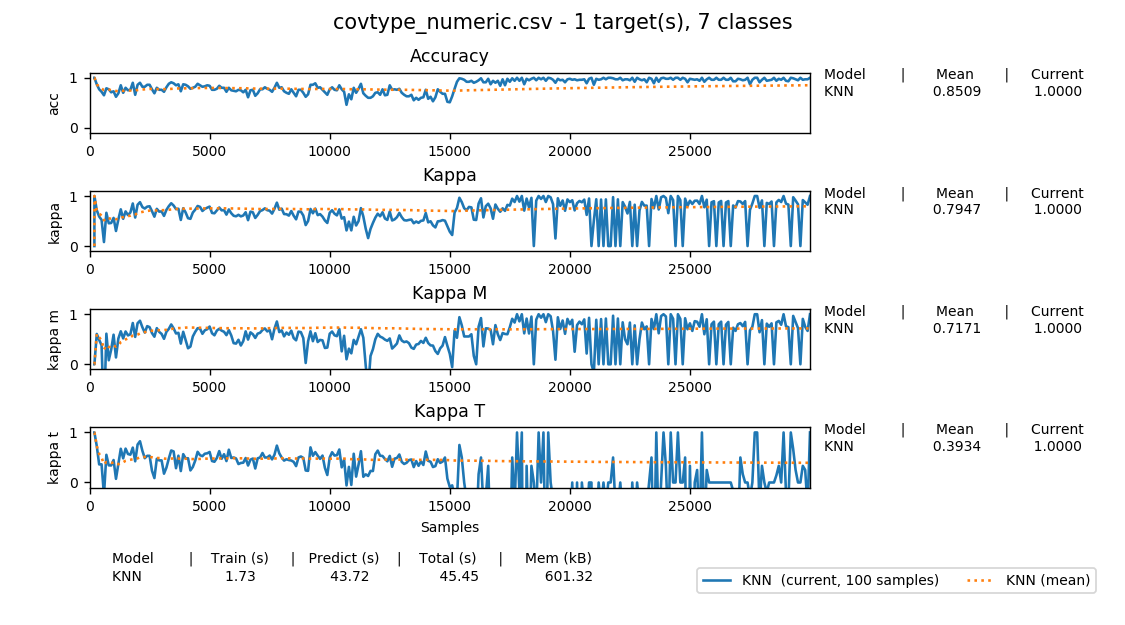

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [55.07s]
Processed samples: 30000
Mean performance:
KNN - Accuracy     : 0.8509
KNN - Kappa        : 0.7947
KNN - Kappa T      : 0.3934
KNN - Kappa M      : 0.7171
KNN - Training time (s)  : 1.73
KNN - Testing time  (s)  : 43.72
KNN - Total time    (s)  : 45.45
KNN - Size (kB)          : 601.3164
Recall per class
Class 0: Ill-defined
Class 1: 0.7887567567567567
Class 2: 0.9245553643144004
Class 3: 0.6752886836027714
Class 4: 0.8101317957166392
Class 5: 0.7992930086410055
Class 6: 0.7550807712350183
Class 7: 0.8762080073630925


In [12]:
#Evaluating all methods together
evaluator.evaluate(stream = stream_, model = [knn_data_], model_names = ['KNN'])
cm = evaluator.get_mean_measurements(0).confusion_matrix

print("Recall per class")
for i in range(cm.n_classes):
    recall = cm.data[(i,i)]/cm.sum_col[i] \
    if cm.sum_col[i] != 0 else 'Ill-defined'
    print("Class {}: {}".format(i, recall))

###### KNN(k = 10, w = 1000, maj)

In [13]:
knn_2 = KNNClassifier(n_neighbors = 10)
knn_2

KNNClassifier(leaf_size=30, max_window_size=1000, metric='euclidean',
              n_neighbors=10, weighted_vote=None)

<IPython.core.display.Javascript object>


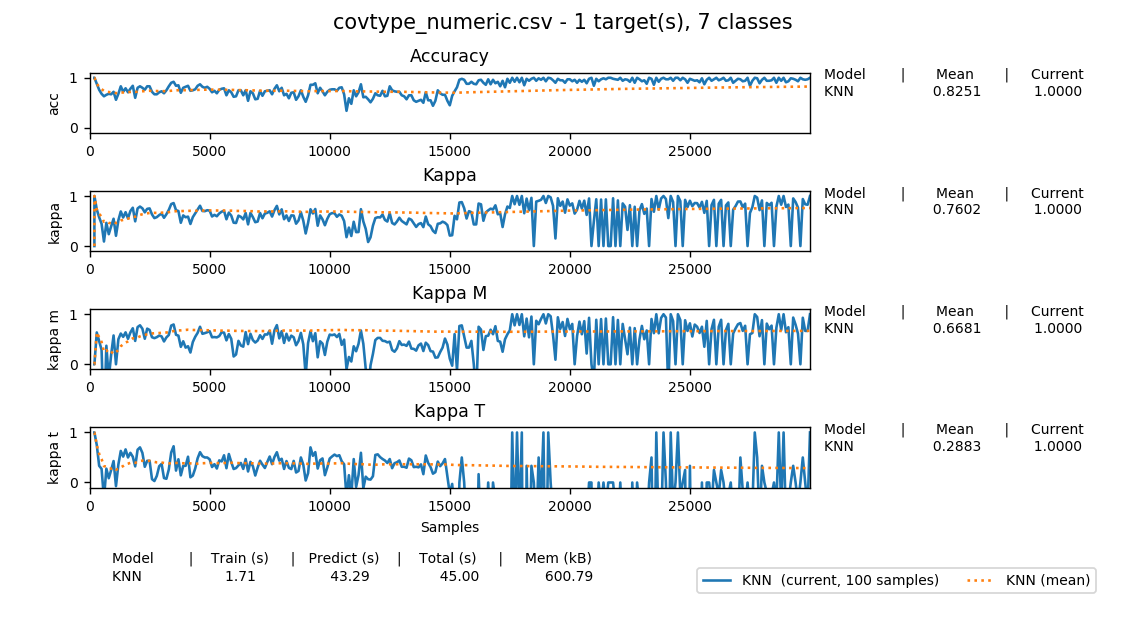

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [54.68s]
Processed samples: 30000
Mean performance:
KNN - Accuracy     : 0.8251
KNN - Kappa        : 0.7602
KNN - Kappa T      : 0.2883
KNN - Kappa M      : 0.6681
KNN - Training time (s)  : 1.71
KNN - Testing time  (s)  : 43.29
KNN - Total time    (s)  : 45.00
KNN - Size (kB)          : 600.7852
Recall per class
Class 0: Ill-defined
Class 1: 0.7456743798207213
Class 2: 0.9217206818348087
Class 3: 0.6232473993668024
Class 4: 0.7692913385826772
Class 5: 0.7490362374710872
Class 6: 0.7111597374179431
Class 7: 0.8496066635816751


In [14]:
#Evaluating all methods together
evaluator.evaluate(stream = stream_, model = [knn_2], model_names = ['KNN'])
cm = evaluator.get_mean_measurements(0).confusion_matrix

print("Recall per class")
for i in range(cm.n_classes):
    recall = cm.data[(i,i)]/cm.sum_col[i] \
    if cm.sum_col[i] != 0 else 'Ill-defined'
    print("Class {}: {}".format(i, recall))

###### KNN(k = 10, w = 1000, weighted)

<IPython.core.display.Javascript object>


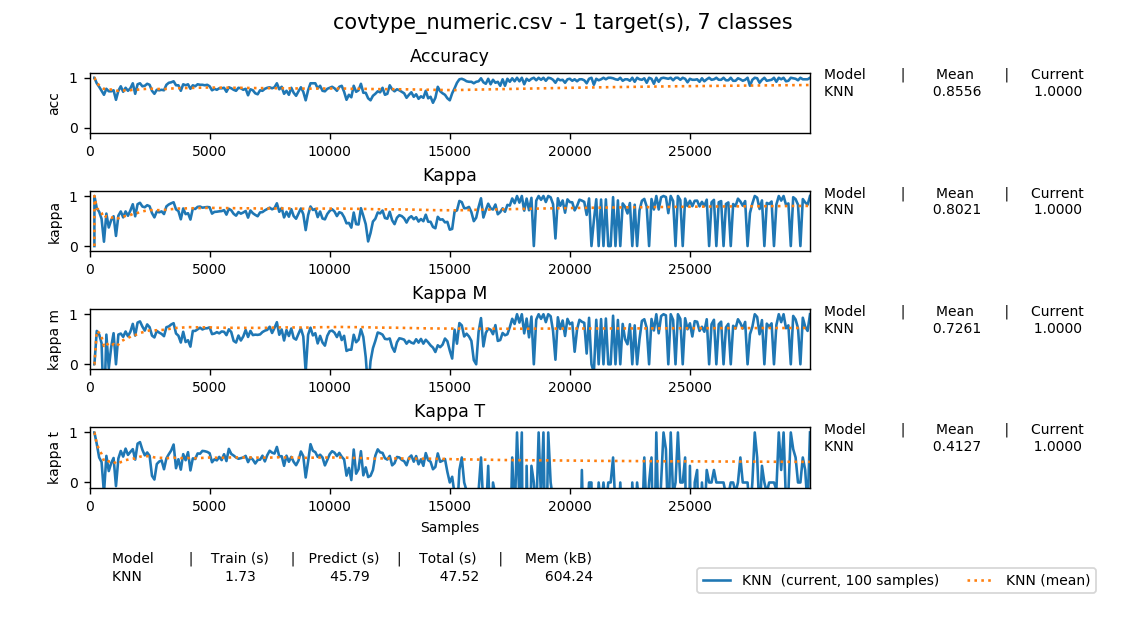

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [57.29s]
Processed samples: 30000
Mean performance:
KNN - Accuracy     : 0.8556
KNN - Kappa        : 0.8021
KNN - Kappa T      : 0.4127
KNN - Kappa M      : 0.7261
KNN - Training time (s)  : 1.73
KNN - Testing time  (s)  : 45.79
KNN - Total time    (s)  : 47.52
KNN - Size (kB)          : 604.2441
Recall per class
Class 0: Ill-defined
Class 1: 0.8082866741321388
Class 2: 0.933187931661214
Class 3: 0.7108792846497765
Class 4: 0.7939441604404247
Class 5: 0.7776954427565765
Class 6: 0.7504901960784314
Class 7: 0.8634573304157549


In [17]:
k_weighted = MyKNNClassifier(n_neighbors = 10, weighted_vote = True)
k_weighted

evaluator.evaluate(stream = stream_, model = [k_weighted], model_names = ['KNN'])
cm = evaluator.get_mean_measurements(0).confusion_matrix

print("Recall per class")
for i in range(cm.n_classes):
    recall = cm.data[(i,i)]/cm.sum_col[i] \
    if cm.sum_col[i] != 0 else 'Ill-defined'
    print("Class {}: {}".format(i, recall))

###### Hoeffding Tree (lp = majority class)

In [18]:
ht_data_ = HoeffdingTreeClassifier(leaf_prediction = 'mc')

<IPython.core.display.Javascript object>


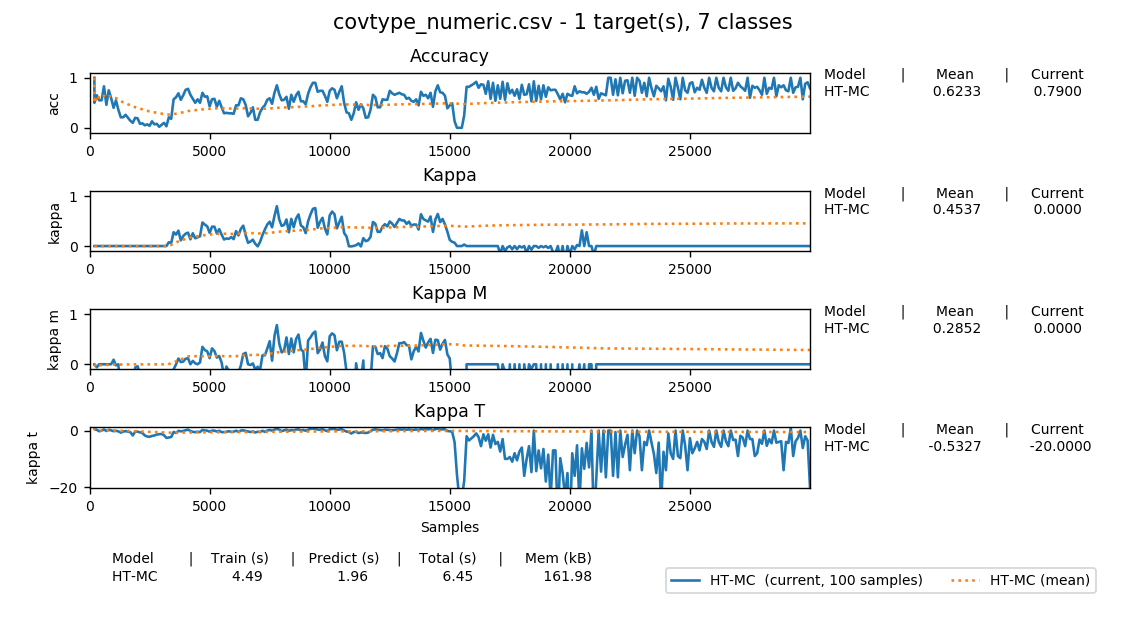

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [12.72s]
Processed samples: 30000
Mean performance:
HT-MC - Accuracy     : 0.6233
HT-MC - Kappa        : 0.4537
HT-MC - Kappa T      : -0.5327
HT-MC - Kappa M      : 0.2852
HT-MC - Training time (s)  : 4.49
HT-MC - Testing time  (s)  : 1.96
HT-MC - Total time    (s)  : 6.45
HT-MC - Size (kB)          : 161.9814
Recall per class
Class 0: Ill-defined
Class 1: 0.4661214953271028
Class 2: 0.700335143880735
Class 3: 0.347568988173456
Class 4: 0.6128917378917379
Class 5: 0.37459165154264973
Class 6: 0.4649421375085092
Class 7: 0.7585278276481149


In [19]:
#Evaluating all methods together
evaluator.evaluate(stream = stream_, model = [ht_data_], model_names = ['HT-MC'])
cm = evaluator.get_mean_measurements(0).confusion_matrix

print("Recall per class")
for i in range(cm.n_classes):
    recall = cm.data[(i,i)]/cm.sum_col[i] \
    if cm.sum_col[i] != 0 else 'Ill-defined'
    print("Class {}: {}".format(i, recall))

###### Hoeffding Tree (lp = Naive Bayes)

<IPython.core.display.Javascript object>


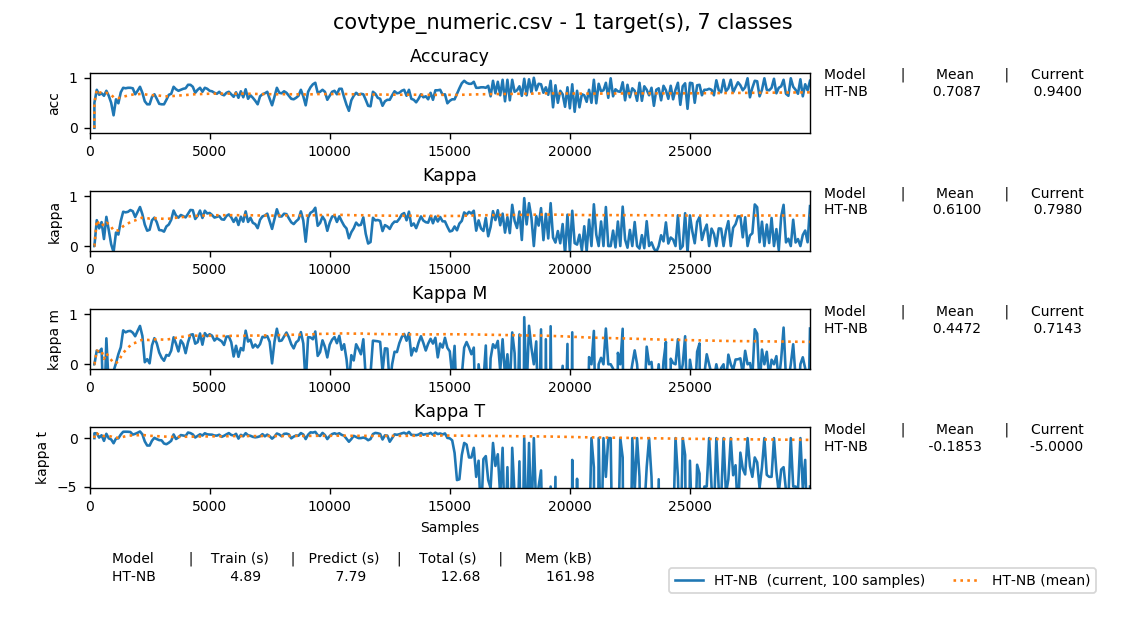

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [19.06s]
Processed samples: 30000
Mean performance:
HT-NB - Accuracy     : 0.7087
HT-NB - Kappa        : 0.6100
HT-NB - Kappa T      : -0.1853
HT-NB - Kappa M      : 0.4472
HT-NB - Training time (s)  : 4.89
HT-NB - Testing time  (s)  : 7.79
HT-NB - Total time    (s)  : 12.68
HT-NB - Size (kB)          : 161.9814
Recall per class
Class 0: 0.0
Class 1: 0.5342109821583232
Class 2: 0.847167325428195
Class 3: 0.594050343249428
Class 4: 0.7748513169073916
Class 5: 0.49550333623440673
Class 6: 0.6445916114790287
Class 7: 0.8510223953261928


In [20]:
htnb_data_ = HoeffdingTreeClassifier(leaf_prediction = 'nb')

#Evaluating all methods together
evaluator.evaluate(stream = stream_, model = [htnb_data_], model_names = ['HT-NB'])
cm = evaluator.get_mean_measurements(0).confusion_matrix

print("Recall per class")
for i in range(cm.n_classes):
    recall = cm.data[(i,i)]/cm.sum_col[i] \
    if cm.sum_col[i] != 0 else 'Ill-defined'
    print("Class {}: {}".format(i, recall))

###### Naive Bayes

<IPython.core.display.Javascript object>


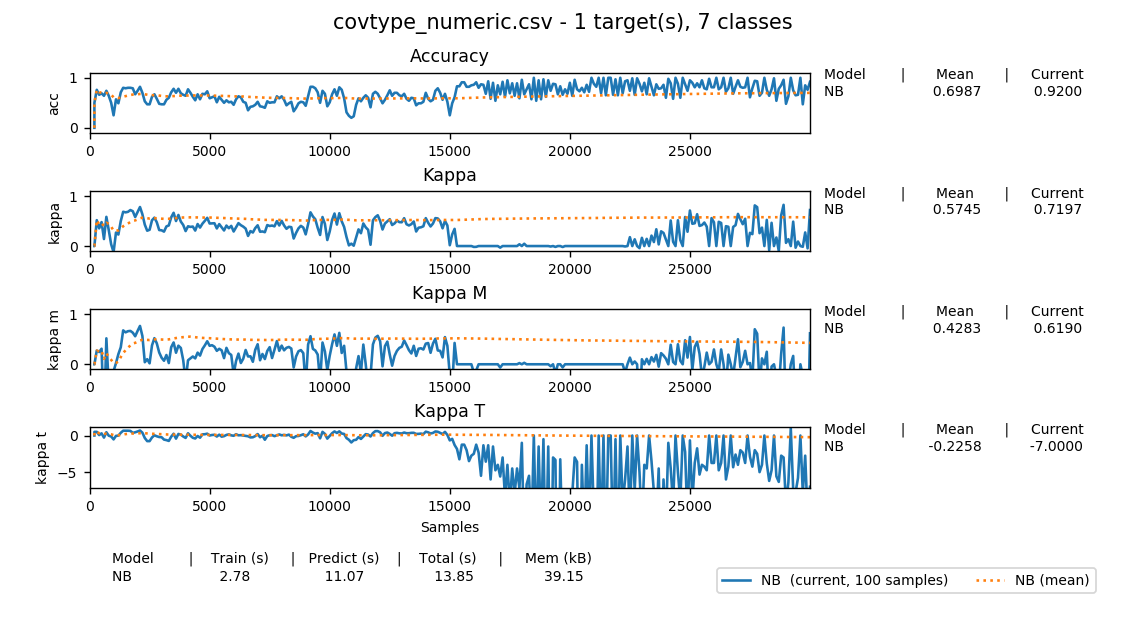

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [19.81s]
Processed samples: 30000
Mean performance:
NB - Accuracy     : 0.6987
NB - Kappa        : 0.5745
NB - Kappa T      : -0.2258
NB - Kappa M      : 0.4283
NB - Training time (s)  : 2.78
NB - Testing time  (s)  : 11.07
NB - Total time    (s)  : 13.85
NB - Size (kB)          : 39.1475
Recall per class
Class 0: Ill-defined
Class 1: 0.5494307968843619
Class 2: 0.786369761920041
Class 3: 0.5431918008784773
Class 4: 0.6897445390596075
Class 5: 0.5366602687140115
Class 6: 0.5067873303167421
Class 7: 0.7763751127141569


In [21]:
nb_data_ = NaiveBayes()

#Evaluating all methods together
evaluator.evaluate(stream = stream_, model = [nb_data_], model_names = ['NB'])
cm = evaluator.get_mean_measurements(0).confusion_matrix

print("Recall per class")
for i in range(cm.n_classes):
    recall = cm.data[(i,i)]/cm.sum_col[i] \
    if cm.sum_col[i] != 0 else 'Ill-defined'
    print("Class {}: {}".format(i, recall))

###### Hoeffding Tree (Default)

<IPython.core.display.Javascript object>


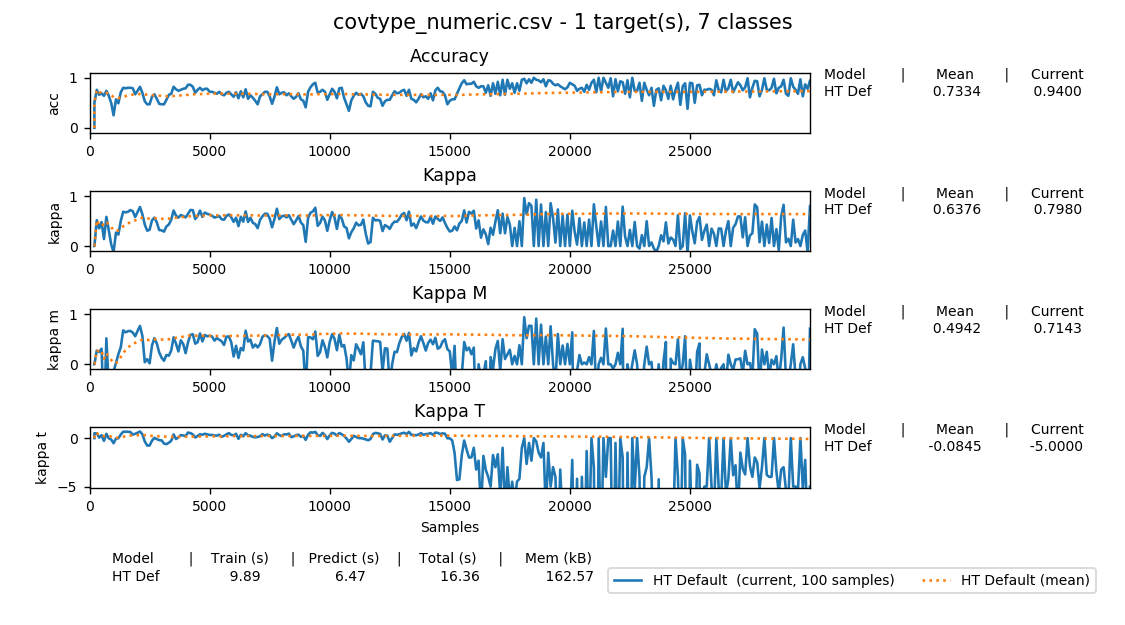

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [22.72s]
Processed samples: 30000
Mean performance:
HT Default - Accuracy     : 0.7334
HT Default - Kappa        : 0.6376
HT Default - Kappa T      : -0.0845
HT Default - Kappa M      : 0.4942
HT Default - Training time (s)  : 9.89
HT Default - Testing time  (s)  : 6.47
HT Default - Total time    (s)  : 16.36
HT Default - Size (kB)          : 162.5742
Recall per class
Class 0: 0.0
Class 1: 0.5373243292571637
Class 2: 0.8531211750305998
Class 3: 0.594493700419972
Class 4: 0.7700377675199328
Class 5: 0.6257943925233644
Class 6: 0.6421348314606742
Class 7: 0.8161993769470405


In [22]:
ht_default = HoeffdingTreeClassifier()

#Evaluating all methods together
evaluator.evaluate(stream = stream_, model = [ht_default], model_names = ['HT Default'])
cm = evaluator.get_mean_measurements(0).confusion_matrix

print("Recall per class")
for i in range(cm.n_classes):
    recall = cm.data[(i,i)]/cm.sum_col[i] \
    if cm.sum_col[i] != 0 else 'Ill-defined'
    print("Class {}: {}".format(i, recall))

###### KNN(k = 10, w = 1000, std = True)

In [23]:
std_knn = MyKNNClassifier(n_neighbors = 10, standardize = True)
std_knn

MyKNNClassifier(leaf_size=30, max_window_size=1000, metric='euclidean',
                n_neighbors=10, standardize=True, weighted_vote=False)

<IPython.core.display.Javascript object>


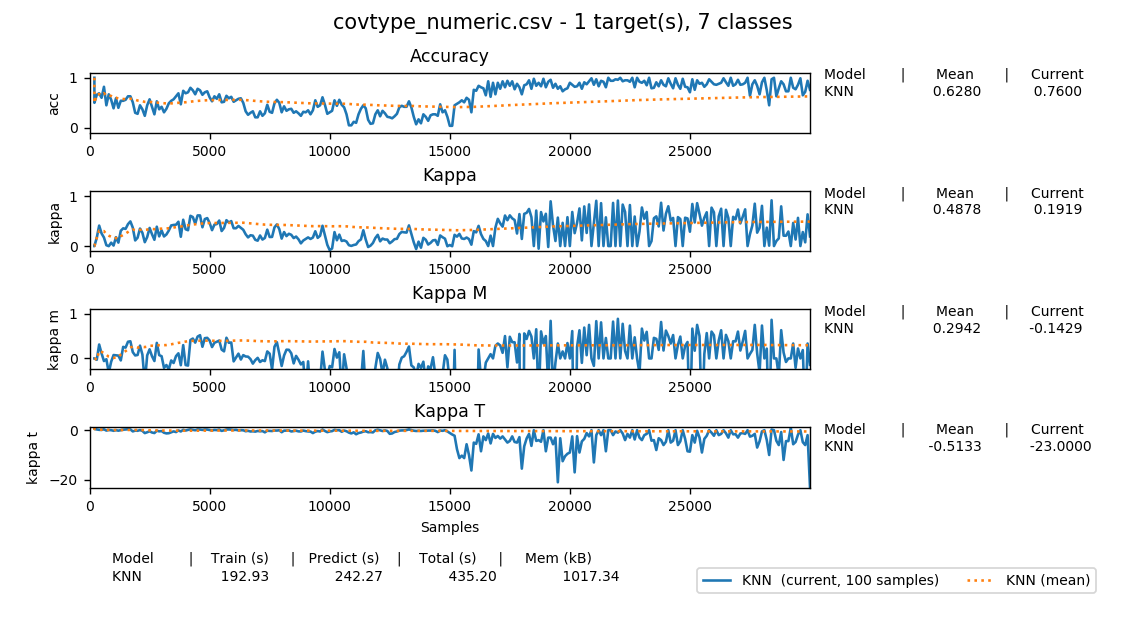

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [471.62s]
Processed samples: 30000
Mean performance:
KNN - Accuracy     : 0.6280
KNN - Kappa        : 0.4878
KNN - Kappa T      : -0.5133
KNN - Kappa M      : 0.2942
KNN - Training time (s)  : 192.93
KNN - Testing time  (s)  : 242.27
KNN - Total time    (s)  : 435.20
KNN - Size (kB)          : 1017.3418
Recall per class
Class 0: Ill-defined
Class 1: 0.49147442326980945
Class 2: 0.8353271836264053
Class 3: 0.3045662100456621
Class 4: 0.5585842148087876
Class 5: 0.41247974068071314
Class 6: 0.3425092641609317
Class 7: 0.5010341261633919


In [24]:
evaluator.evaluate(stream = stream_, model = [std_knn], model_names = ['KNN'])
cm = evaluator.get_mean_measurements(0).confusion_matrix

print("Recall per class")
for i in range(cm.n_classes):
    recall = cm.data[(i,i)]/cm.sum_col[i] \
    if cm.sum_col[i] != 0 else 'Ill-defined'
    print("Class {}: {}".format(i, recall))

###### Random Forest Classifier (Ensemble 1)

In [29]:
hatc = HoeffdingAdaptiveTreeClassifier()

<IPython.core.display.Javascript object>


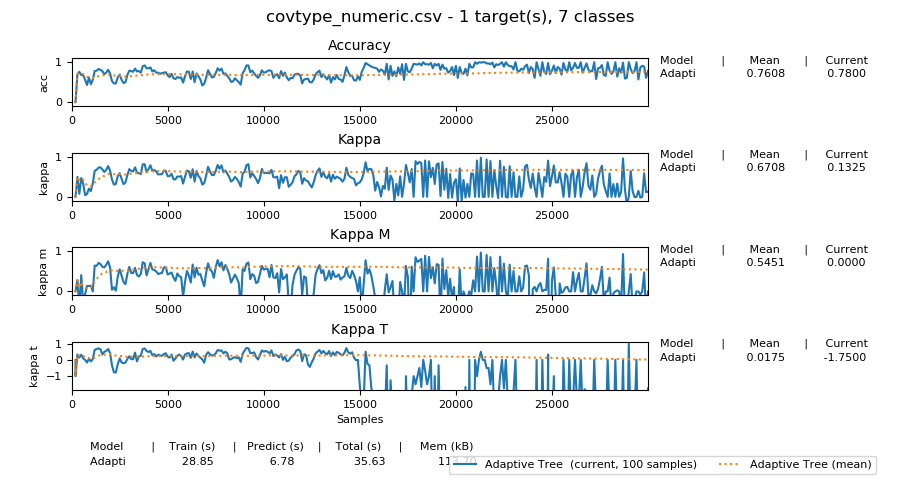

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [42.37s]
Processed samples: 30000
Mean performance:
Adaptive Tree - Accuracy     : 0.7608
Adaptive Tree - Kappa        : 0.6708
Adaptive Tree - Kappa T      : 0.0175
Adaptive Tree - Kappa M      : 0.5451
Adaptive Tree - Training time (s)  : 28.85
Adaptive Tree - Testing time  (s)  : 6.78
Adaptive Tree - Total time    (s)  : 35.63
Adaptive Tree - Size (kB)          : 113.6963
Recall per class
Class 0: 0.0
Class 1: 0.6176530404718324
Class 2: 0.855740780832792
Class 3: 0.5850657615613067
Class 4: 0.8043672014260249
Class 5: 0.6698564593301436
Class 6: 0.6539289558665231
Class 7: 0.8385036496350365


In [30]:
evaluator.evaluate(stream = stream_, model = [hatc], model_names = ['Adaptive Tree'])
cm = evaluator.get_mean_measurements(0).confusion_matrix

print("Recall per class")
for i in range(cm.n_classes):
    recall = cm.data[(i,i)]/cm.sum_col[i] \
    if cm.sum_col[i] != 0 else 'Ill-defined'
    print("Class {}: {}".format(i, recall))

<IPython.core.display.Javascript object>


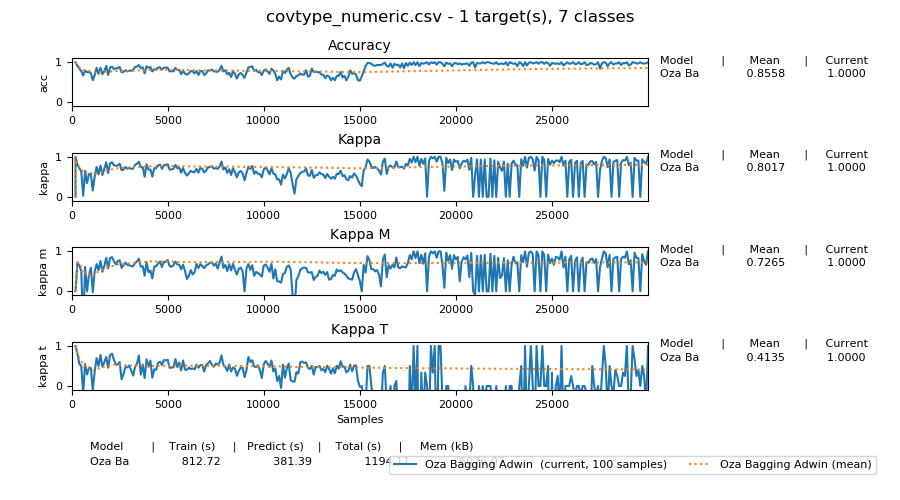

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [1255.06s]
Processed samples: 30000
Mean performance:
Oza Bagging Adwin - Accuracy     : 0.8558
Oza Bagging Adwin - Kappa        : 0.8017
Oza Bagging Adwin - Kappa T      : 0.4135
Oza Bagging Adwin - Kappa M      : 0.7265
Oza Bagging Adwin - Training time (s)  : 812.72
Oza Bagging Adwin - Testing time  (s)  : 381.39
Oza Bagging Adwin - Total time    (s)  : 1194.11
Oza Bagging Adwin - Size (kB)          : 6076.0703
Recall per class
Class 0: Ill-defined
Class 1: 0.8092485549132948
Class 2: 0.9290127891938497
Class 3: 0.6987487969201155
Class 4: 0.8077393075356415
Class 5: 0.7923371647509578
Class 6: 0.7432701894317049
Class 7: 0.8680089485458613


In [17]:
ooza = OzaBaggingAdwin()
evaluator.evaluate(stream = stream_, model = [ooza], model_names = ['Oza Bagging Adwin'])
cm = evaluator.get_mean_measurements(0).confusion_matrix

print("Recall per class")
for i in range(cm.n_classes):
    recall = cm.data[(i,i)]/cm.sum_col[i] \
    if cm.sum_col[i] != 0 else 'Ill-defined'
    print("Class {}: {}".format(i, recall))

<IPython.core.display.Javascript object>


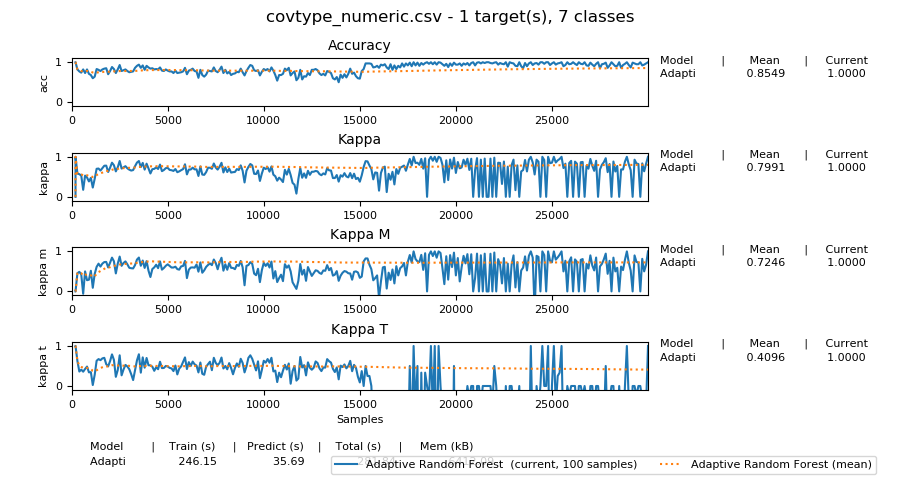

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [314.50s]
Processed samples: 30000
Mean performance:
Adaptive Random Forest - Accuracy     : 0.8549
Adaptive Random Forest - Kappa        : 0.7991
Adaptive Random Forest - Kappa T      : 0.4096
Adaptive Random Forest - Kappa M      : 0.7246
Adaptive Random Forest - Training time (s)  : 246.15
Adaptive Random Forest - Testing time  (s)  : 35.69
Adaptive Random Forest - Total time    (s)  : 281.84
Adaptive Random Forest - Size (kB)          : 6412.0879
Recall per class
Class 0: Ill-defined
Class 1: 0.7994120307553143
Class 2: 0.9118430273300631
Class 3: 0.7340680402491615
Class 4: 0.8410404624277457
Class 5: 0.8061692371821593
Class 6: 0.7788210745957225
Class 7: 0.8462549277266754


In [21]:
arf = AdaptiveRandomForest()
evaluator.evaluate(stream = stream_, model = [arf], model_names = ['Adaptive Random Forest'])
cm = evaluator.get_mean_measurements(0).confusion_matrix

print("Recall per class")
for i in range(cm.n_classes):
    recall = cm.data[(i,i)]/cm.sum_col[i] \
    if cm.sum_col[i] != 0 else 'Ill-defined'
    print("Class {}: {}".format(i, recall))